<a href="https://colab.research.google.com/github/VavRe/nlp-ut/blob/main/CA3/Q1_Twitter_Sentiment_Analysis_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
!unzip trainingandtestdata.zip

--2023-05-12 15:26:35--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2023-05-12 15:26:35--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  16.7MB/s    in 6.1s    

2023-05-12 15:26:42 (12.8 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]

Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


In [48]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout, RNN
from keras.models import Sequential


In [28]:
columns = ["sentiment","id","datetime","query","user","tweet"]
df = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", encoding="latin-1", names=columns)

In [29]:
df["sentiment"].value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

In [30]:
df = df.loc[:,["sentiment","tweet"]]
df

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [31]:
from sklearn.model_selection import train_test_split

samples_fraction = 0.2
stratify_on = "sentiment"

_, dataset = train_test_split(df, stratify=df[stratify_on], 
                                 test_size=samples_fraction,
                                 random_state=76)

# Reset the index of the sampled DataFrame
dataset.reset_index(drop=True, inplace=True)


In [32]:
dataset["sentiment"].value_counts()

4    160000
0    160000
Name: sentiment, dtype: int64

In [33]:
onehot = pd.get_dummies(dataset['sentiment'])
onehot.columns = ["0","4"]
dataset = pd.concat([dataset, onehot], axis=1)
dataset['label'] = dataset.apply(lambda row: [row['0'], row['4']], axis=1)
dataset

,sentiment,tweet,0,4,label
0,4,Photo: monorail cat Itâs face makes me lol ...,0,1,"[0, 1]"
1,4,@BADxTHAD,0,1,"[0, 1]"
2,4,@Caroline_S Good for you And I will become a ...,0,1,"[0, 1]"
3,4,I am drinking a wonderful monster.,0,1,"[0, 1]"
4,4,"@headbandana ha! For the most part, yes! Love u.",0,1,"[0, 1]"
...,...,...,...,...,...
319995,4,By the way - if I don't know you personally th...,0,1,"[0, 1]"
319996,4,@johnnykile that was really deep,0,1,"[0, 1]"
319997,4,Another year has gone by... it's all good,0,1,"[0, 1]"
319998,4,@QueenMiMiFan Wouah! It cool is to work over t...,0,1,"[0, 1]"


In [34]:
del df

In [67]:
X_train, X_test, y_train, y_test = train_test_split(dataset['tweet'], dataset['sentiment'], test_size=0.2, random_state=76)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=76)


In [36]:
X_val.shape

(25600,)

In [43]:
vocab_size = 15000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

In [44]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [45]:
# Pad the sequences to a fixed length
max_length = 150
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)


In [49]:
!pip install kaggle ;
!mkdir ~/.kaggle/ ;
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/ ;
!chmod 600 ~/.kaggle/kaggle.json ;
!kaggle datasets download -d rtatman/glove-global-vectors-for-word-representation
!unzip /content/glove-global-vectors-for-word-representation.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle/’: File exists
100% 457M/458M [00:23<00:00, 23.4MB/s]
100% 458M/458M [00:23<00:00, 20.7MB/s]
Archive:  /content/glove-global-vectors-for-word-representation.zip
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.50d.txt        


In [50]:
# # Use one-hot vectors for one option
# X_train_onehot = tokenizer.sequences_to_matrix(X_train_seq, mode='binary')
# X_test_onehot = tokenizer.sequences_to_matrix(X_test_seq, mode='binary')

# Use GloVe embeddings for another option
embeddings_index = {}
with open('glove.6B.200d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [88]:
from keras.utils import to_categorical
y_train = y_train.replace(4,1)
y_train_onehot = to_categorical(y_train, num_classes=2)
y_test = y_test.replace(4,1)
y_test_onehot = to_categorical(y_test, num_classes=2)



In [86]:
from keras.callbacks import ModelCheckpoint
from keras.layers import CuDNNLSTM, Dropout

filepath = 'my_best_model.hdf5'

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
opt = tf.keras.optimizers.Adam(learning_rate=0.01)


model_glove = Sequential()
model_glove.add(Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False))
model_glove.add(CuDNNLSTM (64))
model_glove.add(Dropout(0.2))
model_glove.add(Dense(2, activation='softmax'))
model_glove.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


hist = model_glove.fit(X_train_pad, y_train_onehot, epochs=100, batch_size=128, validation_split=0.2, callbacks=[checkpoint,callback])


Epoch 1/100
1435/1440 [============================>.] - ETA: 0s - loss: 0.6299 - accuracy: 0.6527
Epoch 1: val_loss improved from inf to 0.58661, saving model to my_best_model.hdf5
1440/1440 [==============================] - 16s 10ms/step - loss: 0.6297 - accuracy: 0.6528 - val_loss: 0.5866 - val_accuracy: 0.6922
Epoch 2/100
1434/1440 [============================>.] - ETA: 0s - loss: 0.6150 - accuracy: 0.6680
Epoch 2: val_loss did not improve from 0.58661
1440/1440 [==============================] - 13s 9ms/step - loss: 0.6151 - accuracy: 0.6680 - val_loss: 0.5944 - val_accuracy: 0.6863
Epoch 3/100
1434/1440 [============================>.] - ETA: 0s - loss: 0.6429 - accuracy: 0.6336
Epoch 3: val_loss did not improve from 0.58661
1440/1440 [==============================] - 13s 9ms/step - loss: 0.6430 - accuracy: 0.6335 - val_loss: 0.6268 - val_accuracy: 0.6486
Epoch 4/100
1434/1440 [============================>.] - ETA: 0s - loss: 0.6527 - accuracy: 0.6223
Epoch 4: val_loss did no

ValueError: ignored

In [96]:
y_pred = model_glove.predict(X_test_pad)

2000/2000 [==============================] - 6s 3ms/step


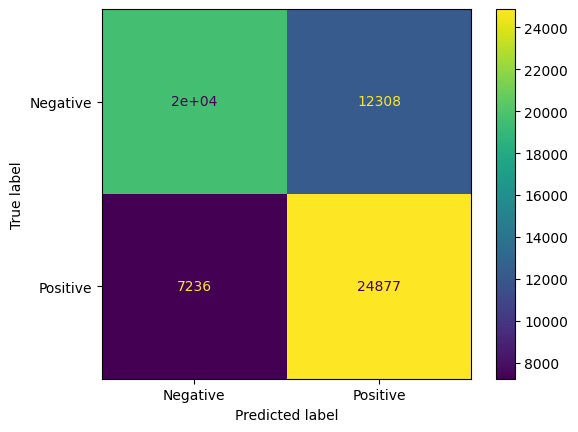

In [99]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_onehot, axis=1)
conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=['Negative', 'Positive'])
disp.plot()
plt.show()


In [101]:
from sklearn.metrics import classification_report
target_names = ["Negative","Positive"]
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))


              precision    recall  f1-score   support

    Negative       0.73      0.61      0.67     31887
    Positive       0.67      0.77      0.72     32113

    accuracy                           0.69     64000
   macro avg       0.70      0.69      0.69     64000
weighted avg       0.70      0.69      0.69     64000

